In [1]:
import rebound
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd
from scipy.interpolate import interp1d
import pymc3 as pm
import scipy
from scipy.integrate import quad

plt.style.use('paper.mplstyle')
%matplotlib inline

In [2]:
dfttvs = pd.read_csv("../csvs/Kepler-23_TTVs.csv", index_col=0)
dfttvs.tail()

,mu1,per1,h1,k1,Tc1,mu2,per2,h2,k2,Tc2,...,mean_long2,pomega3,e3,mean_long3,ecom,Mstar,Z12,Zcom12,Z23,Zcom23
249995,0.000003,7.105870,-0.038511,-0.196506,57.031001,0.000006,10.743525,0.032910,-0.196457,55.659821,...,5.147323,-1.075444,0.199238,4.333169,0.195363,1.078,0.057635,0.225596,0.052881,0.202704
249996,0.000003,7.106110,-0.069445,0.025974,56.975209,0.000006,10.743671,0.000208,-0.003399,55.525812,...,5.226137,-0.406624,0.062597,4.431526,0.002368,1.078,0.048025,0.029160,0.047266,0.025114
249997,0.000004,7.106614,-0.001841,-0.075112,57.111239,0.000004,10.743291,0.044821,-0.081911,55.689775,...,5.129095,-0.580675,0.077984,4.414196,0.075583,1.078,0.039443,0.087027,0.029059,0.090064
249998,0.000003,7.106508,-0.087985,0.084049,56.927508,0.000004,10.743239,-0.016223,0.039809,55.475669,...,5.254157,0.894684,0.026970,4.517402,0.044281,1.078,0.048541,0.084225,0.025173,0.031786
249999,0.000004,7.106154,-0.122730,-0.000055,56.853333,0.000009,10.743234,-0.046245,-0.023290,55.364239,...,5.319310,-2.470655,0.004345,4.557613,0.066148,1.078,0.045537,0.083135,0.029900,0.047405


In [3]:
dfstab = pd.read_csv('../csvs/Kepler-23_stability.csv', index_col=0)
dfstab.tail()

,sim,Mstar,Z12,Z23,mu1,mu2,mu3,e1,e2,e3,...,h3,k1,k2,k3,ecom,ejection,t_instability,nbodystable,crossing,spockprob
27048,1999380.0,0.880613,0.201456,0.102933,2.729311e-06,0.000012,0.000003,0.198727,0.155031,0.014555,...,0.013028,-0.172274,0.117442,0.006489,0.101288,False,5.358731e+04,False,True,0.010296
27049,1999466.0,1.214257,0.028857,0.021840,8.367568e-07,0.000042,0.000007,0.039781,0.010983,0.022669,...,-0.022128,-0.000577,-0.010441,0.004925,0.008076,False,1.000000e+09,True,False,0.787886
27050,1999693.0,1.225737,0.075364,0.066737,9.338099e-06,0.000078,0.000004,0.088874,0.108052,0.175515,...,-0.001799,-0.037102,-0.107794,-0.175506,0.104393,False,6.319852e+04,False,False,0.009134
27051,1999943.0,1.083352,0.130137,0.077125,1.474248e-06,0.000006,0.000018,0.224166,0.236365,0.140135,...,0.055326,0.024470,-0.146544,-0.128751,0.156694,False,2.133985e+04,False,False,0.005355
27052,1999969.0,1.159434,0.045962,0.052065,3.549245e-06,0.000037,0.000085,0.095140,0.020418,0.050637,...,0.047178,-0.075962,-0.010202,0.018394,0.026185,False,6.663452e+04,False,False,0.014513


In [4]:
dftd = pd.read_csv('../csvs/Kepler-23_transitdurations.csv', index_col=0)
dftd.tail()

,ID,Mstar,Z12,Zcom12,Z23,Zcom23,e1,e2,e3,mu1,...,mu1+mu2,mu2+mu3,mutot,h1,h2,h3,k1,k2,k3,ecom
39995,39995.0,1.078,0.255003,0.219557,0.241333,0.209461,0.127092,0.284903,0.147279,0.000017,...,0.000058,0.000057,0.000074,0.042600,-0.283499,0.053627,0.119740,0.028253,0.137169,0.151633
39996,39996.0,1.078,0.167385,0.060251,0.100135,0.029410,0.262542,0.001692,0.130529,0.000008,...,0.000044,0.000046,0.000054,0.076042,0.001623,0.034801,-0.251288,0.000479,0.125804,0.023035
39997,39997.0,1.078,0.312784,0.203727,0.270524,0.179126,0.392362,0.198785,0.305235,0.000019,...,0.000056,0.000060,0.000079,-0.091950,-0.185938,-0.106741,-0.381435,0.070304,-0.285963,0.199702
39998,39998.0,1.078,0.427050,0.347575,0.235435,0.420197,0.124926,0.495464,0.299385,0.000012,...,0.000033,0.000038,0.000050,0.101222,-0.392509,-0.034320,0.073216,0.302360,0.297411,0.289026
39999,39999.0,1.078,0.622924,0.460641,0.089562,0.727858,0.023163,0.722732,0.518803,0.000013,...,0.000029,0.000028,0.000040,-0.001221,-0.302022,-0.204131,-0.023130,0.656600,0.476957,0.430164


# calcHPDI calculates the highest posterior density interval

Other two functions are to plot what it's doing

In [5]:
def calcHPDI(vals, interval, guess, weights=None):
    '''
    Fit a gaussian KDE, find max likelihood, and calculate 
    minimum interval that holds `interval` percentage of the distribution.
    This is what Hadden 2017 quote

        vals : array of values
        interval: float for size of interval
        guess: initial guess for max likelihood
    '''
    vals = np.concatenate([vals, vals*(-1)]) # reflect values to negative to avoid edge effects at zero
    try:
        weights=np.concatenate([weights, weights])
    except:
        pass
    
    kde = scipy.stats.gaussian_kde(vals, bw_method=1/15, weights=weights)
    maxlike = scipy.optimize.fmin(lambda x: -kde(x), x0=guess, disp=False)[0]
    
    sample = kde.resample(10000, seed=0) # need to do this step in case we need to weight the vals by weights (for SPOCK probs)
    samplecut = sample[sample > 0]

    low, high = pm.stats.hpd(samplecut, credible_interval=interval)
    return kde, maxlike, high, low

def plotposterior(ax, vals, interval, guess, weights=None, lim=1, hist=True, lines=True):
    kde, maxlike, high, low = calcHPDI(vals, interval, guess, weights=weights)
    
    vals = np.concatenate([vals, vals*(-1)]) # reflect values to negative to avoid edge effects at zero
    try:
        weights=np.concatenate([weights, weights])
    except:
        pass
    
    if hist:
        ax.hist(vals, alpha=0.5, density=True, weights=weights, bins=100, range=[-lim, lim])
    xs = np.linspace(0,lim,1000)
    ax.plot(xs, kde(xs))
    
    ax.axvline(low, linestyle='--', c='k', alpha=0.3)
    ax.axvline(high, linestyle='--', c='k', alpha=0.3)
    ax.axvline(maxlike, c='k', alpha=0.3)
    ax.set_xlim([0,lim])
    ax.set_ylim([0, ax.get_ylim()[1]])
    return maxlike, high, low

def tableline(method, df, cols, lim=0.4):
    fig, axarr = plt.subplots(ncols=len(cols), figsize=(6*len(cols), 6))
    line = "{0}\t".format(method)
    for i, col in enumerate(cols):
        maxlike, high, low = plotposterior(axarr[i], df[col], 0.683, guess=0.1, lim=lim, hist=True)
        if np.abs(low) >= 0.0005:
            line += "&\t[{0:.3f}, {1:.3f}]\t".format(low, high)
        else:
            line += "&\t[0, {0:.3f}]\t".format(high)
    line += "\\\\"
    print(line)

# Plot of KDEs of the posterior and highest posterior density intervals for transit durations:

Transit Durations	&	[0, 0.312]	&	[0, 0.416]	&	[0, 0.308]	\\


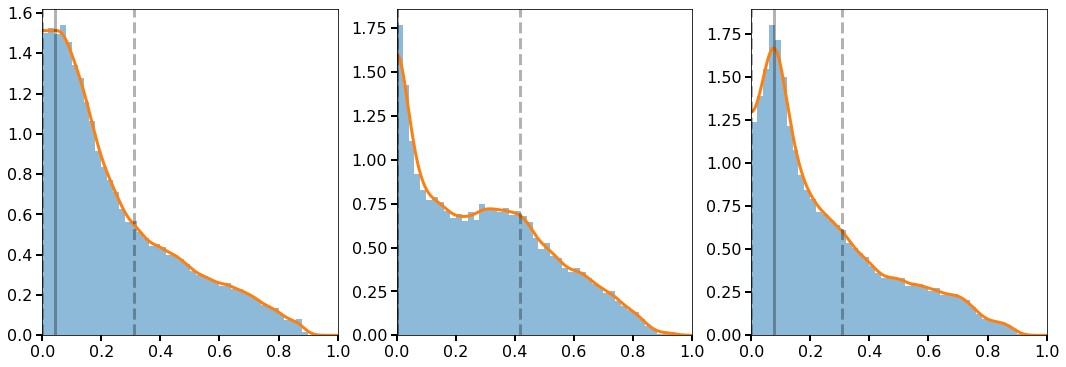

In [6]:
tableline('Transit Durations', dftd, ['e1', 'e2', 'e3'], lim=1)

# Plot Comparisons

In [7]:
def plot(ax, col, xlabel, range, Nbins, labels=False):
    if labels:
        ax.hist(dfstab[col][:10000], color='gray', alpha=0.5, density=True, label="Prior", bins=40)
    else:
        ax.hist(dfstab[col][:10000], color='gray', alpha=0.5, density=True, bins=40)

    label = "Transit Durations\n" if labels else ""
    kde, maxlike, high, low = calcHPDI(dftd[col], interval=0.683, guess=0.1)
    if np.abs(low) >= 0.005:
        label += "[{0:.2f}, {1:.2f}]".format(low, high)
    else:
        label += "[0, {0:.2f}]".format(high)
    ax.hist(dftd[col], alpha=0.5, density=True, label=label, bins=40, range=[0,1])
    
    label = "Stability\n" if labels else ""
    kde, maxlike, high, low = calcHPDI(dfstab[stable][col], interval=0.683, guess=0.1)
    if np.abs(low) >= 0.005:
        label += "[{0:.2f}, {1:.2f}]".format(low, high)
    else:
        label += "[0, {0:.2f}]".format(high)
    vals, bins, _ = ax.hist(dfstab[stable][col], alpha=0.5, density=True, label=label, bins=Nbins, range=range)
    
    label = "Transit Time Variations\n" if labels else ""
    kde, maxlike, high, low = calcHPDI(dfttvs[col], interval=0.683, guess=0.1)
    if np.abs(low) >= 0.005:
        label += "[{0:.2f}, {1:.2f}]".format(low, high)
    else:
        label += "[0, {0:.2f}]".format(high)
    
    ax.hist(dfttvs[col], alpha=0.5, density=True, bins=bins, label=label)
    
    ax.set_xlabel(xlabel)

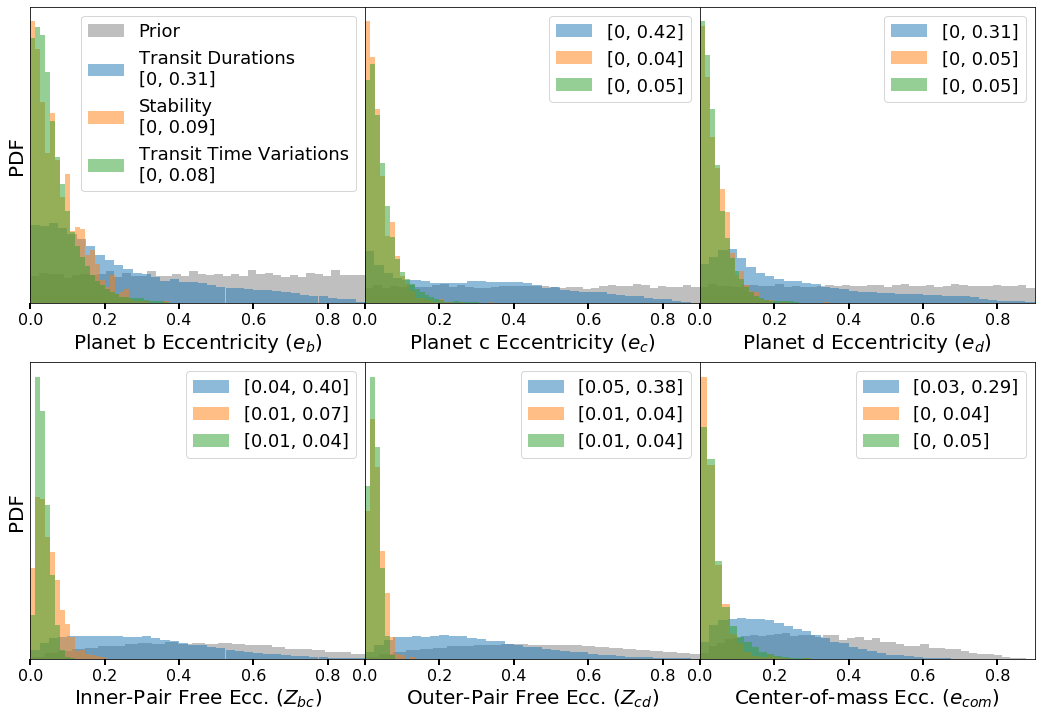

In [8]:
stable = (dfstab['nbodystable'] == 1.)
fig, axarr = plt.subplots(nrows=2, ncols=3, figsize=(18,12))
plt.subplots_adjust(wspace=0)

plot(axarr[0,0], 'e1', 'Planet b Eccentricity ($e_b$)', labels=True, range=[0, 0.4], Nbins=30)
plot(axarr[0,1], 'e2', 'Planet c Eccentricity ($e_c$)', range=[0, 0.4], Nbins=30)
plot(axarr[0,2], 'e3', 'Planet d Eccentricity ($e_d$)', range=[0, 0.4], Nbins=30)
plot(axarr[1,0], 'Z12', 'Inner-Pair Free Ecc. ($Z_{bc}$)', range=[0, 0.2], Nbins=15)
plot(axarr[1,1], 'Z23', 'Outer-Pair Free Ecc. ($Z_{cd}$)', range=[0, 0.2], Nbins=15)
plot(axarr[1,2], 'ecom', 'Center-of-mass Ecc. ($e_{com}$)', range=[0, 0.3], Nbins=15)

for ax in axarr.flatten():
    ax.set_xlim([0,0.9])
    ax.axes.yaxis.set_ticks([])
    ax.legend(fontsize=18)

axarr[0,0].set_ylabel('PDF')
axarr[1,0].set_ylabel('PDF')
fig.savefig('eccentricitycomparison.pdf', bbox_inches='tight')